# Part II - Prosper Loan Analysis
## by Adedeji Yakub

## Investigation Overview

In this investigation, I wish to explore patterns and insights in the loan business. I will show how various features affect the Amount of Loan given(LoanOriginationAmount) and the amount paid back monthly (MonthlyLoanPayment)


## Dataset Overview

This document explores a dataset containing loan amount, Borrower Income( Stated Monthly Income), Debt-Income-Ratio, Loan Term, Prosper Score, and many others for approximately 114,000 rows of loan data.<br>

For better understanding of variables, [Here's a link to the data dictionary](https://docs.google.com/spreadsheets/u/0/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit?usp=sharing)

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
#extracting relevant columns
df = df[['ListingNumber','Term', 'LoanStatus', 'IncomeRange',
             'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 
             'EmploymentStatus', 'EmploymentStatusDuration', 'DebtToIncomeRatio', 'IsBorrowerHomeowner',
             'StatedMonthlyIncome', 'LoanOriginalAmount', 'LoanOriginationDate', 'LoanOriginationQuarter', 'MonthlyLoanPayment']]

df_clean = df.copy()
#sorting out the null problems
df_clean = df_clean[df_clean['ProsperScore'].notnull()]
df_clean = df_clean[df_clean['ProsperRating (Alpha)'].notnull()]
df_clean = df_clean[df_clean['DebtToIncomeRatio'].notnull()]

df_clean['Occupation'] = df_clean['Occupation'].fillna('Unknown')
df_clean = df_clean[df_clean['EmploymentStatusDuration'].notnull()]

#sorting out the datatype problems
df_clean['StatedMonthlyIncome'] = df_clean['StatedMonthlyIncome'].astype(np.int32)
df_clean['IsBorrowerHomeowner'].replace(True, 'True', inplace=True)
df_clean['IsBorrowerHomeowner'].replace(False, 'False', inplace=True)
df_clean['LoanOriginationDate'] = pd.to_datetime(df_clean['LoanOriginationDate'])
df_clean['LoanOriginationYear'] = df_clean['LoanOriginationDate'].dt.year
df_clean['LoanOriginationMonth'] = df_clean['LoanOriginationDate'].dt.month
df_clean['LoanOriginationMonth'] = df_clean['LoanOriginationMonth'].replace([1,2,3,4,5,6,7,8,9,10,11,12],
        ['January','Febuary', 'March','April','May','June','July','August','September','October','November','December'])
df_clean['ListingNumber'] = df_clean['ListingNumber'].astype(str)

#for ordered categorical conversion,
ordinal_var_dict = {'LoanStatus': ['Cancelled',  'Chargedoff', 'Completed', 'Current', 'Defaulted', 'FinalPaymentInProgress'
                                   ,'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)',
                                   'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)'],
                    'ProsperRating (Alpha)': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'ProsperScore': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                   'LoanOriginationMonth': ['January','Febuary', 'March','April','May','June','July','August','September',
                                            'October','November','December'],
                   'LoanOriginationYear' : [2009, 2010, 2011, 2012, 2013, 2014],
                   'IncomeRange' : ['Not displayed', 'Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
                                   '$75,000-99,999','$100,000+']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df_clean[var] = df_clean[var].astype(ordered_var)
    
df_clean.EmploymentStatus = df_clean.EmploymentStatus.astype('category')

#The data seems to have a lot of outliers. This needs to be cleaned up
# Using interquartile ranges to detect outliers,
q1 = df_clean['StatedMonthlyIncome'].quantile(0.25)
q3 = df_clean['StatedMonthlyIncome'].quantile(0.75)
iqr = q3 - q1
lowerLimit = q1 - 1.5*iqr  #Lower outlier
upperLimit = q3 + 1.5*iqr  #upper outlier
df_clean = df_clean[df_clean['StatedMonthlyIncome'] < upperLimit]

## Distribution of Loan Amount
Loan Amounts in the dataset are given out in rounded figures and in multiples of 5,000 dollars. Investigating on a smaller bin size, the distribution is Trimodal with majority of loan amount given out at 4,000 , 10,000 and 15,0000 dollars.

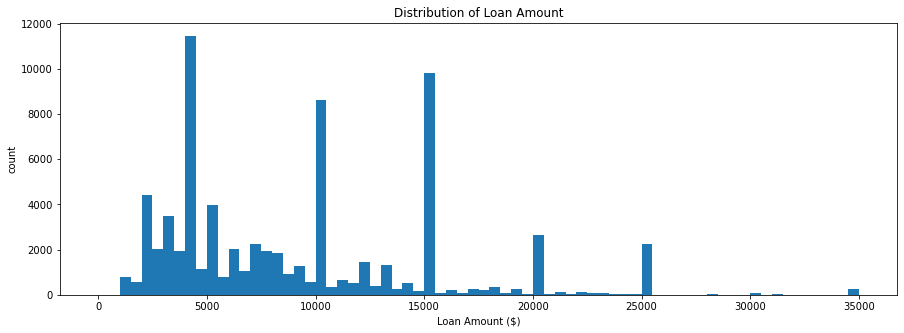

In [4]:
binsize = 500
bins = np.arange(0, df_clean['LoanOriginalAmount'].max()+binsize, binsize)

plt.figure(figsize=[15, 5])
plt.hist(data = df_clean, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Amount ($)')
plt.ylabel('count')
plt.title('Distribution of Loan Amount');
plt.show()

## Distribution of Original Loan Amount
The distribution is unimodal with a large number of Borrowers taking a loan of about $5000.

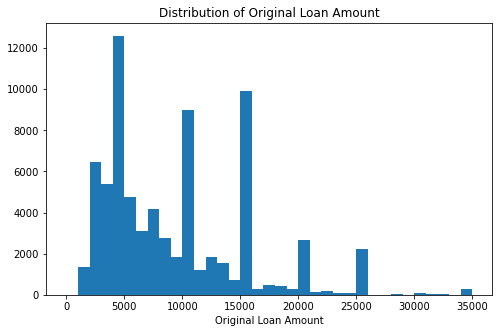

In [5]:
binsize = 1000
bins = np.arange(0, df_clean['LoanOriginalAmount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df_clean, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Original Loan Amount')
plt.title('Distribution of Original Loan Amount');

## Loan Amount Across Loan Term and Monthly Loan Payment

We can see how the categorical variable, Loan Term affects the correlation. Borrowers with longer Loan Term have acces to higher loan amounts.<br>

Also, a longer loan term will result in a smaller Monthly Loan Payment for same amount but shorter term.<br>


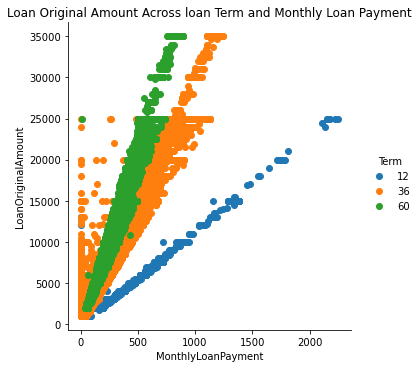

In [6]:
g = sns.FacetGrid(data = df, hue = 'Term', height = 5);
g.map(plt.scatter, 'MonthlyLoanPayment', 'LoanOriginalAmount');
plt.title('Loan Original Amount Across loan Term and Monthly Loan Payment')
g.add_legend();

## Average Loan Amount vs Prosper Risk Score
Generally the Loan Amount increases as the Prosper risk reduces(or Prosper number increases). This shows that low/no risk borrowers have a higher chance of getting larger Loan Amounts.

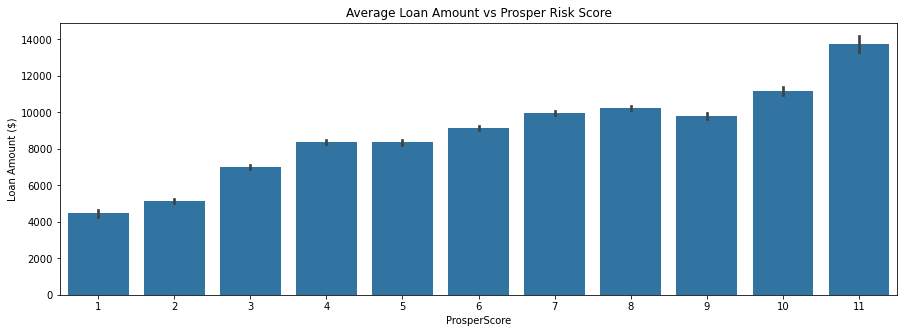

In [7]:
plt.figure(figsize=[15,5])
base_color = sns.color_palette()[0]
sns.barplot(data=df_clean, x='ProsperScore', y='LoanOriginalAmount', color=base_color)
plt.ylabel('Loan Amount ($)');
plt.title('Average Loan Amount vs Prosper Risk Score');

## CONCLUSIONS
It can be observed that more loans were issued in the year 2013 and also during January, October, November and December compared to other months.

To be granted access to large loans one needs to have a good Debt-To-Income-Ratio( preferably 0.50 or lesser) dependent on Loan Type.

To get a large loan as a borrower, I need to get have an Occupation that pays a Large Monthly Income. Or, at least have a Large Monthly Income

Also, I need to have a good prosper Risk Score (10/11) and possibly own a Home as well.

In [15]:
warnings.filterwarnings("ignore")
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck_template.ipynb to slides
[NbConvertApp] Writing 655192 bytes to Part_II_slide_deck_template.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\Yakub Adedeji\anaconda3\envs\personals\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\Yakub Adedeji\anaconda3\envs\personals\lib\site-packages\jupyter_core\application.py", line 269, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "C:\Users\Yakub Adedeji\anaconda3\envs\personals\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\Yakub Adedeji\anaconda3\envs\personals\lib\site-packages\nbconvert\nbconvertapp.py", line 369, in start
    self.convert_notebooks()
  File "C:\Users\Yakub Adedeji\anaconda3\envs\personals\lib\site-packages\n